# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
device

'cuda'

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-14 12:24:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [               <=>  ] 201.24M  59.5MB/s    in 3.7s    

2023-10-14 12:24:08 (53.8 MB/s) - ‘data.txt.zip’ saved [211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
set_random_seed(42)

-----
-----

Предобработаем данные:

-----
-----

In [ ]:
pd.isnull(y).any() # пропусков нет

False

In [ ]:
y.dtype == "object" # категориальных переменных нет

False

In [ ]:
# отмасштабируем признаки, но не будем масштабировать целевую переменную
X = scaler.fit_transform(X)
X = pd.DataFrame(data=X)
X.head(8)

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,1.080575,0.391265,1.826532,0.464657,-0.474730,-0.278204,-1.552371,-1.310845,0.387704,-0.666166,...,-0.085335,0.108508,0.142775,-0.237355,0.049233,-0.356182,0.544458,-0.470599,-0.255977,0.042292
1,0.880919,0.332292,1.748539,0.721828,-0.164945,-1.191173,0.765681,0.109626,1.420941,0.414950,...,-0.314250,0.306236,-0.069483,0.052017,-0.632328,-0.436057,0.556448,0.568744,0.206940,1.158587
2,1.247622,0.592600,1.337173,0.750657,-0.001110,-0.702100,-0.060914,-0.069956,1.166254,-0.074608,...,-0.396186,0.566683,-0.756534,-0.284019,-0.024220,0.223128,-0.509789,-0.338457,0.105819,-0.090208
3,0.801044,-0.061805,0.783683,0.087218,0.329180,-1.298429,0.510714,-1.073355,-0.016803,-1.262655,...,0.586237,-0.559427,-0.478689,-0.890161,-0.793906,0.567269,-0.263107,0.408116,0.967862,0.793384
4,1.249775,0.793334,1.657037,0.447460,-0.406775,-0.567138,-0.692498,-0.952197,0.841844,-0.144910,...,-0.181585,0.099672,0.191319,-0.585576,-0.111877,-0.219960,0.448804,0.256882,0.192038,1.241363
5,1.180137,-0.018881,2.373001,1.300198,-0.829592,-0.740978,1.582814,-0.427709,-0.008714,-1.006591,...,-0.285296,0.129632,-0.126948,-0.199787,-0.040407,-0.101162,0.353490,0.040774,-0.167375,-0.059147
6,1.184717,0.618237,1.187370,0.636414,-0.905221,0.057546,-0.662354,-0.972657,2.351941,0.975765,...,-0.128307,0.563171,0.761535,-0.172690,0.486330,0.155498,0.217803,0.003141,-0.132910,0.003296
7,0.804574,0.149005,1.887609,1.402049,-0.414135,-0.355656,0.721239,-0.010350,0.353320,-0.107270,...,0.071169,0.085410,-0.876282,0.095364,-0.272976,0.338268,0.046073,-0.357019,-0.086504,-0.228836


In [ ]:
# поделим уже отмасштабированные данные на тренировочную выборку и тестовую
train_size = 463715
X_train = X.iloc[:train_size, :]
X_test = X.iloc[train_size:, :]

In [ ]:
from sklearn.linear_model import Ridge

set_random_seed(42)

# обучим Ridge регрессию с произвольным параметром регуляризации alpha=0.05
model = Ridge(alpha=0.05).fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error

rmse_for_model = ((np.square(y_test - y_pred)).mean()) ** (1/2)
rmse_for_model

9.510160713037447

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [ ]:
best_rmse_metric = (np.mean((y_test - np.mean(y_test)) ** 2)) ** (1/2)
best_rmse_metric

10.851909820717683

-----
-----

Даже с произвольным alpha качество Ridge регрессии выше, чем у лучшего константного прогноза.

-----
-----

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

-----
-----

Чтобы получать батчи, создадим класс, который DataLoader будет принимать на вход.

-----
-----

In [ ]:
set_random_seed(42)

In [ ]:
class YearSongDataset(torch.utils.data.Dataset):
    """
    Our dataset for songs
    """

    def __init__(self, datatype: str):

        # набор данных
        df = pd.read_csv('data.txt.zip', header=None)

        separate_X = df.iloc[:, 1:].values
        separate_y = df.iloc[:, 0].values

        # стандартное отклонение и среднее для обратного масштаюирования
        self.tgtstd = np.std(separate_y)
        self.tgtmean = np.mean(separate_y)

        # масштабирование с помощью StandardScaler'а
        df = scaler.fit_transform(df)
        df = pd.DataFrame(data=df)

        train_size = 463715

        # datatype показывает, что нам нужно: тренировочная выборка или тестовая
        if datatype == 'train':
          self.X = torch.tensor(df.iloc[:train_size, 1:].values, dtype=torch.float32)
          self.y = torch.tensor(df.iloc[:train_size, 0].values, dtype=torch.float32).unsqueeze(1)
          self.len = df.iloc[:train_size, :].shape[0]

        elif datatype == 'test':
          self.X = torch.tensor(df.iloc[train_size:, 1:].values, dtype=torch.float32)
          self.y = torch.tensor(df.iloc[train_size:, 0].values, dtype=torch.float32).unsqueeze(1)
          self.len = df.iloc[train_size:, :].shape[0]


    def __len__(self):
        # длина
        return len(self.X)

    def __getitem__(self, idx):
        # значения
        return self.X[idx], self.y[idx]

-----
-----

Воспользуемся DataLoader'ом и укажем размер батча:

-----
-----

In [ ]:
train_set = YearSongDataset(datatype='train')
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=512, shuffle=True, num_workers=1
)

test_set = YearSongDataset(datatype='test')
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=512, shuffle=False, num_workers=1
)

-----
-----

Модель линейной регрессии приведена ниже. Она аналогична той, которая была на семинаре. Будем выводить лосс (MSE) для тренировочной и тестовой выборки после каждой эпохи, а также каждый раз строить соответствующий график (для лучшей визуализации будем полностью отображать train loss, а средний для каждой эпохи test loss будет звёздочкой). В самом конце также выведем метрику RMSE для тренировочной выборки и тестовой по эпохам.

-----
-----

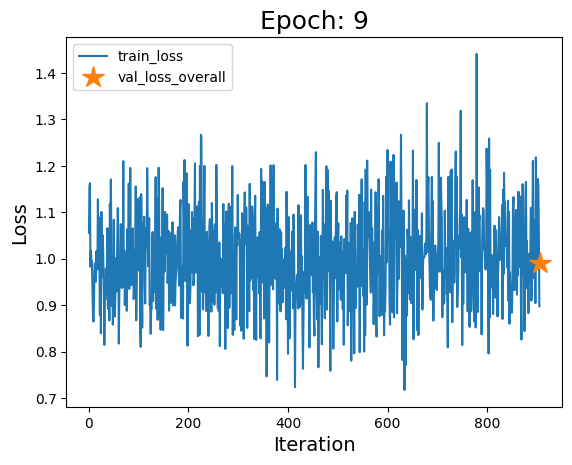

Epoch: 9, train loss (scaled): 1.0017027854919434,
val loss (scaled): 0.9910402894020081, test RMSE: 10.57659380034645


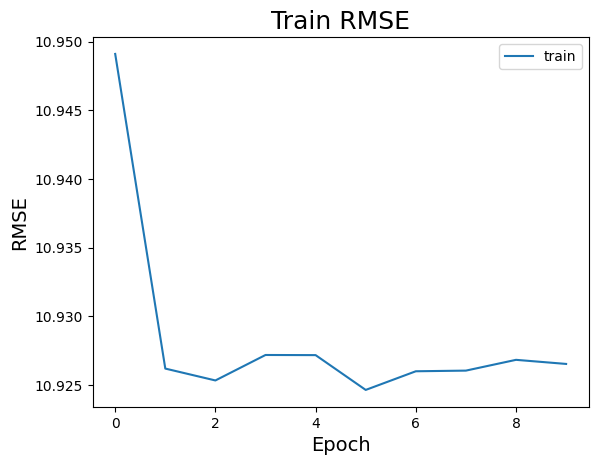

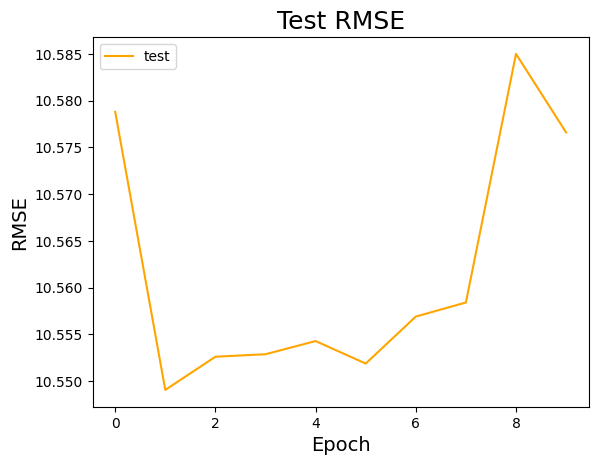

In [ ]:
set_random_seed(42)

# основная функция
def forward(x):
    w.requires_grad = True
    b.requires_grad = True
    return w.to(device) * x + b.to(device)


# лосс
def criteria(y_pred, y):
    return torch.mean((y_pred - y) ** 2)


w = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)

# задаем learning rate и число эпох
step_size = 0.1
n = 10

epoch_RMSE_train = []
epoch_RMSE_val = []

for i in range (n):
  train_loss_list = []
  train_initial_list = []
  for X_train, y_train in tqdm(train_loader): # берем батч из train_loader'а

    X_train = X_train.to(device)
    y_train = y_train.to(device)

    y_pred_train = forward(X_train).to(device)

    loss = criteria(y_pred_train, y_train) # лосс
    train_initial = torch.sqrt(criteria(y_pred_train * test_set.tgtstd + test_set.tgtmean, y_train * test_set.tgtstd + test_set.tgtmean))

    loss.backward() # считаем градиенты обратным проходом
    assert w.grad is not None
    assert b.grad is not None

    # делаем шаг градиентного спуска
    w.data -= step_size * w.grad
    b.data -= step_size * b.grad

    # обнуляем посчитанные значения
    w.grad.data.zero_()
    b.grad.data.zero_()

    train_initial_list.append(train_initial.cpu().detach().numpy().tolist())
    train_loss_list.append(loss.cpu().detach().numpy())

  val_loss_list = []
  RMSE_accuaracy_list = []
  with torch.no_grad():
    for X_val, y_val in tqdm(test_loader): # берем батч из test_loader'а

      X_val = X_val.to(device)
      y_val = y_val.to(device)
      y_pred_val = forward(X_val).to(device)

      loss = criteria(y_pred_val, y_val) # лосс

      val_loss_list.append(loss.cpu().detach().numpy())

      val_initial = torch.sqrt(criteria(y_pred_val * test_set.tgtstd + test_set.tgtmean, y_val * test_set.tgtstd + test_set.tgtmean))
      RMSE_accuaracy_list.append(val_initial.cpu().detach().numpy().tolist())

  clear_output(True) # графики меняют друг друга

  plt.plot(train_loss_list, label='train_loss')
  plt.plot(len(train_loss_list), np.mean(val_loss_list), '*', markersize=16, label='val_loss_overall')
  plt.xlabel("Iteration", fontsize=14)
  plt.ylabel("Loss", fontsize=14)
  plt.title(f"Epoch: {i}", fontsize=18)
  plt.legend()
  plt.show()

  print(f"Epoch: {i}, train loss (scaled): {np.mean(train_loss_list)},\nval loss (scaled): {np.mean(val_loss_list)}, test RMSE: {np.mean(RMSE_accuaracy_list)}")
  epoch_RMSE_train.append(np.mean(train_initial_list))
  epoch_RMSE_val.append(np.mean(RMSE_accuaracy_list))

plt.plot(epoch_RMSE_train, label='train') # train RMSE
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title("Train RMSE", fontsize=18)
plt.legend()
plt.show()

plt.plot(epoch_RMSE_val, label='test', color='orange') # test RMSE
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title("Test RMSE", fontsize=18)
plt.legend()
plt.show()

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [ ]:
train_set = YearSongDataset(datatype='train')
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=128, shuffle=True, num_workers=1
)

test_set = YearSongDataset(datatype='test')
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=128, shuffle=False, num_workers=1
)

In [ ]:
# batch размером 128
model = nn.Sequential(
    nn.Linear(90, 512), nn.LeakyReLU(), nn.Dropout(0.2),
    nn.Linear(512, 256), nn.LeakyReLU(), nn.Dropout(0.2),
    nn.Linear(256, 128), nn.LeakyReLU(), nn.Dropout(0.2),
    nn.Linear(128, 1)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
criterion = torch.nn.MSELoss()

In [ ]:
def train(model, optimizer, criterion, train_loader, test_loader, n):
    '''
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
        n - число эпох
    '''

    train_RMSE_for_epochs = []
    val_RMSE_for_epochs = []

    set_random_seed(42)

    for epoch in range(n):
        train_loss = []
        train_RMSE_list = []
        for X_train, y_train in tqdm(train_loader): # берем батч из train_loader'а
            X_train = X_train.to(device) # на устройство
            y_train = y_train.to(device)
            y_pred = (model(X_train)).to(device)
            loss = (criterion(y_pred, y_train))
            train_initial_loss = torch.sqrt(criterion(y_pred * test_set.tgtstd + test_set.tgtmean, y_train * test_set.tgtstd + test_set.tgtmean))
            train_RMSE_list.append(train_initial_loss.cpu().detach().numpy().tolist())
            loss.backward() # считаем градиенты обратным проходом
            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(loss.cpu().detach().numpy())

        val_loss = []
        RMSE_accuaracy = []
        with torch.no_grad():
            for X_val, y_val in tqdm(test_loader): # берем батч из test_loader'а
                X_val = X_val.to(device) # на устройство
                y_val = y_val.to(device)
                val_pred = model(X_val).to(device)
                loss = (criterion(val_pred, y_val))
                val_loss.append(loss.cpu().numpy())
                val_initial_loss = torch.sqrt(criterion(val_pred * test_set.tgtstd + test_set.tgtmean, y_val * test_set.tgtstd + test_set.tgtmean))
                RMSE_accuaracy.append(val_initial_loss.cpu().numpy().tolist())


        clear_output(True) # графики меняют друг друга

        plt.plot(train_loss, label='train_loss')
        plt.plot(len(train_loss), np.mean(val_loss), '*', markersize=16, label='val_loss_overall')
        plt.xlabel("Iteration", fontsize=14)
        plt.ylabel("Loss", fontsize=14)
        plt.title(f"Epoch: {epoch}", fontsize=18)
        plt.legend()
        plt.show()

        print(f"Epoch: {epoch}, train loss: {np.mean(train_loss)}, test RMSE: {np.mean(RMSE_accuaracy)}")


        # можно останавливаться после той эпохи, где RMSE <= 8.75

        # if np.mean(RMSE_accuaracy) <= 8.75:
            # print('Final RMSE: ', np.mean(RMSE_accuaracy))
            # break
        train_RMSE_for_epochs.append(np.mean(train_RMSE_list))
        val_RMSE_for_epochs.append(np.mean(RMSE_accuaracy))

    plt.plot(train_RMSE_for_epochs, label='train')
    plt.plot(val_RMSE_for_epochs, label='test')
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)
    plt.title("Train and Test RMSE", fontsize=18)
    plt.legend()
    plt.show()


def test(model, criterion, test_loader):
    '''
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    '''

    with torch.no_grad():
        X = test_loader.dataset.X.to(device) # на устройство
        y = test_loader.dataset.y.to(device)
        y_pred = model(X).cpu().detach().numpy()
        return y_pred * test_set.tgtstd + test_set.tgtmean

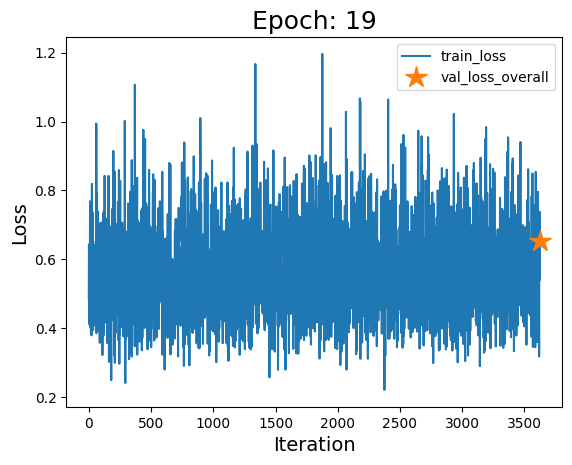

Epoch: 19, train loss: 0.5597957372665405, test RMSE: 8.176879428990997


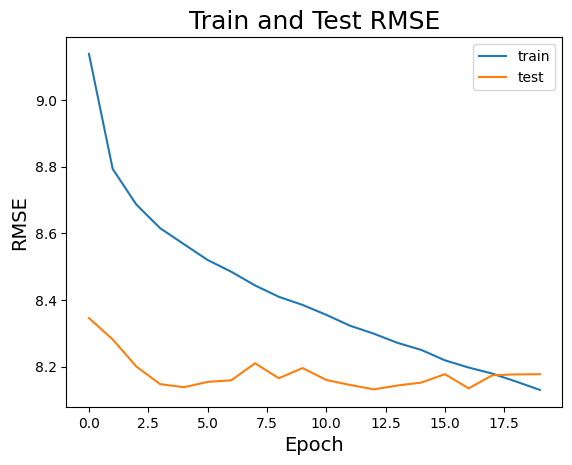

In [ ]:
train(model, optimizer, criterion, train_loader, test_loader, n=20)

In [ ]:
# всё хорошо
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

-----
-----

# Отчет об экспериментах

Стоит сказать, что даже первые модели были удачными, потому что я изначально сделал нормализацию целевой переменной. В то же время с самого начала я выбирал не очень примитивные архитектуры и старался подбирать адекватные значения гиперпараметров, например, значение learning rate.

Для всех экспериментов число эпох равно 20.


# Эксперимент 1
Модель выглядела так:

In [ ]:
# batch размером 512
model = nn.Sequential(
    nn.Linear(90, 512), nn.ReLU(),
    nn.Linear(512, 256), nn.ReLU(),
    nn.Linear(256, 128), nn.ReLU(),
    nn.Linear(128, 1)).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
criterion = torch.nn.MSELoss()

После 20 эпох (далее будет скриншот графиков, надеюсь, он загрузится):

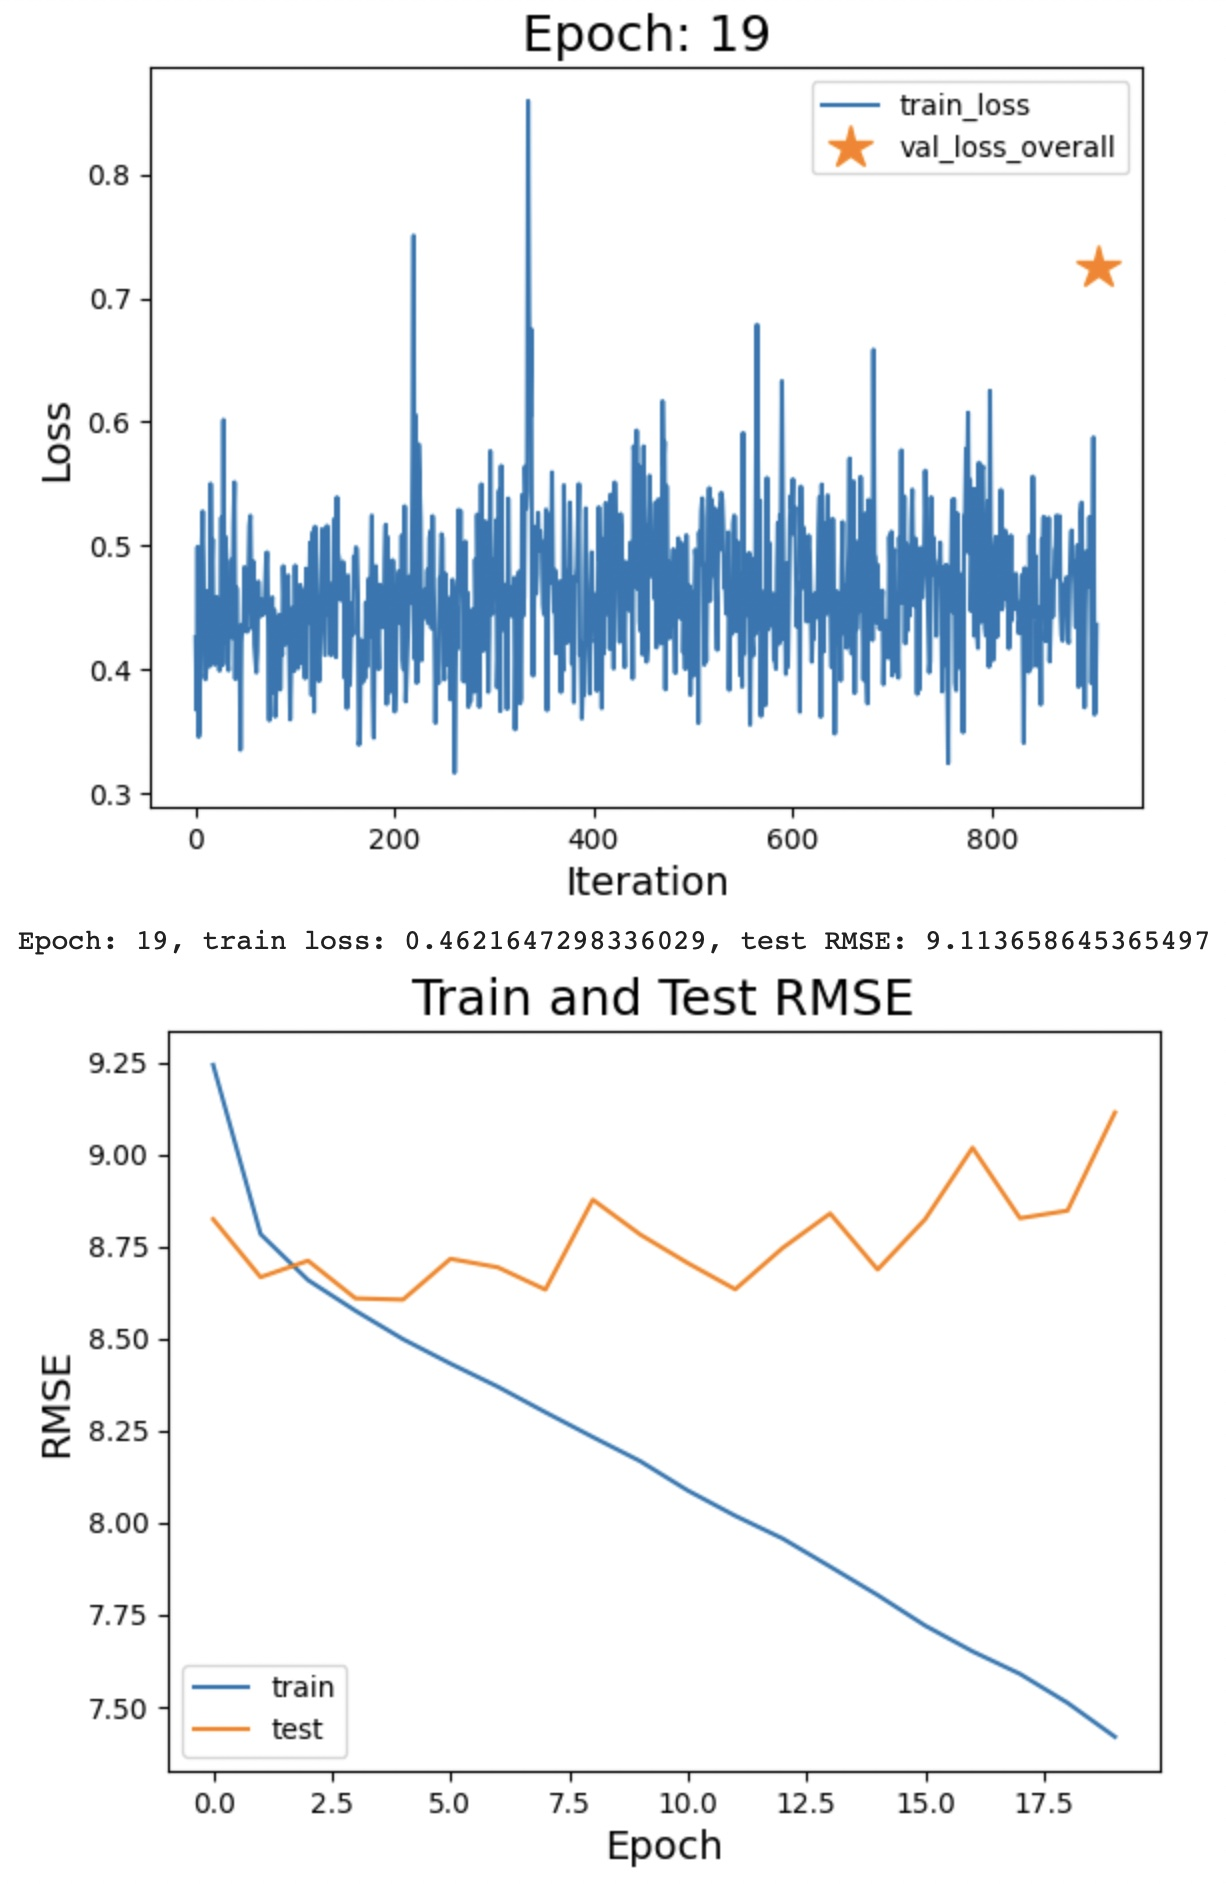


В целом уже хорошо. Train loss во время обучения снижался, что было видно по выводимой после каждой эпохи текстовой строки, значит, всё работает верно. В середине обучение test RMSE даже был меньше 8.75, то есть можно было остановиться. Но есть ощущение, что модель переобучилась, поэтому её надо улучшить.

# Эксперимент 2

Чтобы уйти от переобучения, добавил в модель nn.Dropout(0.2) после nn.ReLU() для нескольких слоев, она стала выглядеть так:

In [ ]:
# batch размером 512
model = nn.Sequential(
    nn.Linear(90, 512), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(128, 1)).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
criterion = torch.nn.MSELoss()

Теперь после 20 эпох:

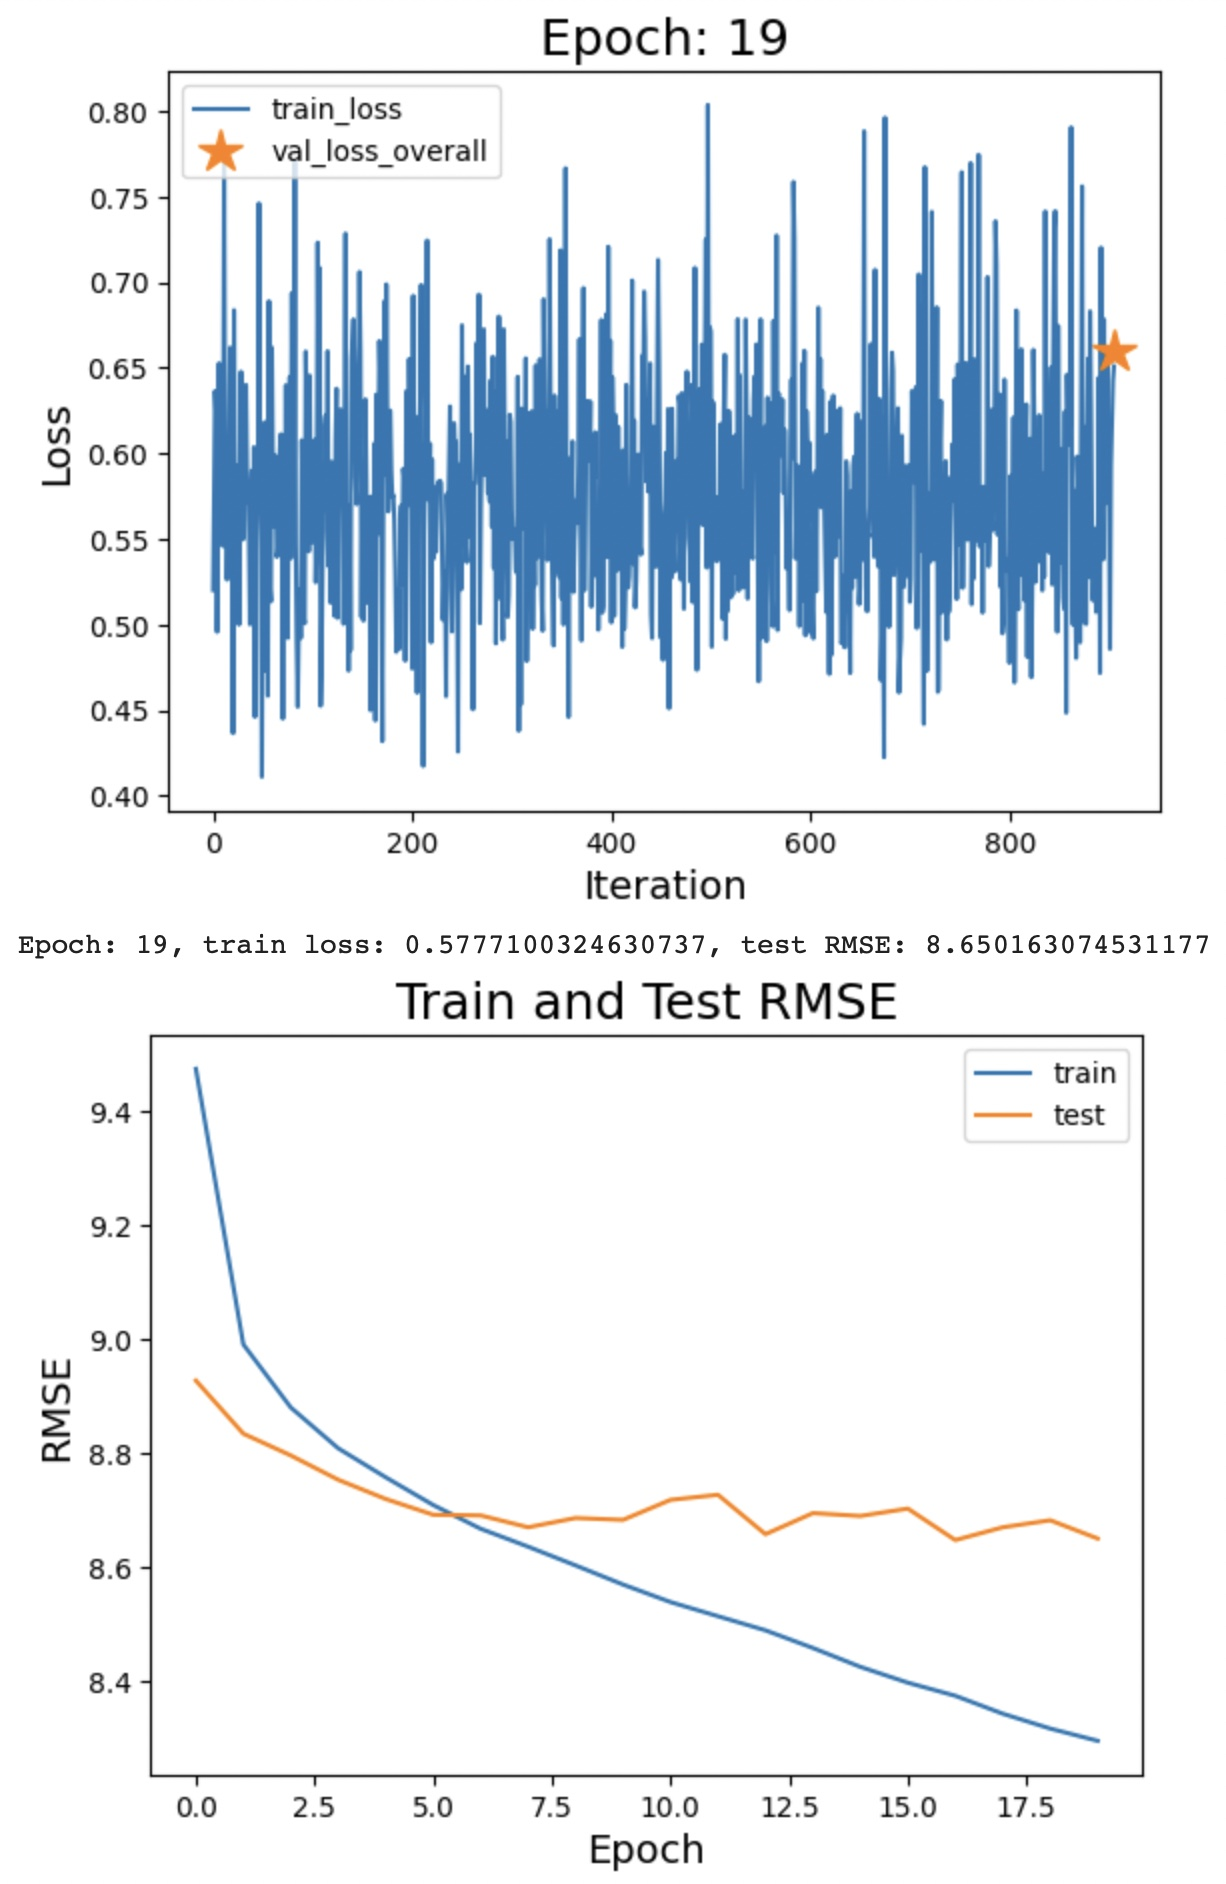

Намного лучше! Train loss по-прежнему снижался, а переобучение стало значительно меньше. К 20-й эпохе test RMSE стал 8.65 (меньше 8.75), то есть теперь можно было не делать досрочную остановку. Но хотелось ещё сделать так, чтобы на первой же эпохе test RMSE стал меньше 8.75.

# Эксперимент 3

На лекции нам рассказывали, что предпочтительно брать небольшой размер батча, поэтому попробовал уменьшить его с 512 до 128 и взял модель из 2-го эксперимента:

In [ ]:
# batch размером 128
model = nn.Sequential(
    nn.Linear(90, 512), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(128, 1)).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
criterion = torch.nn.MSELoss()

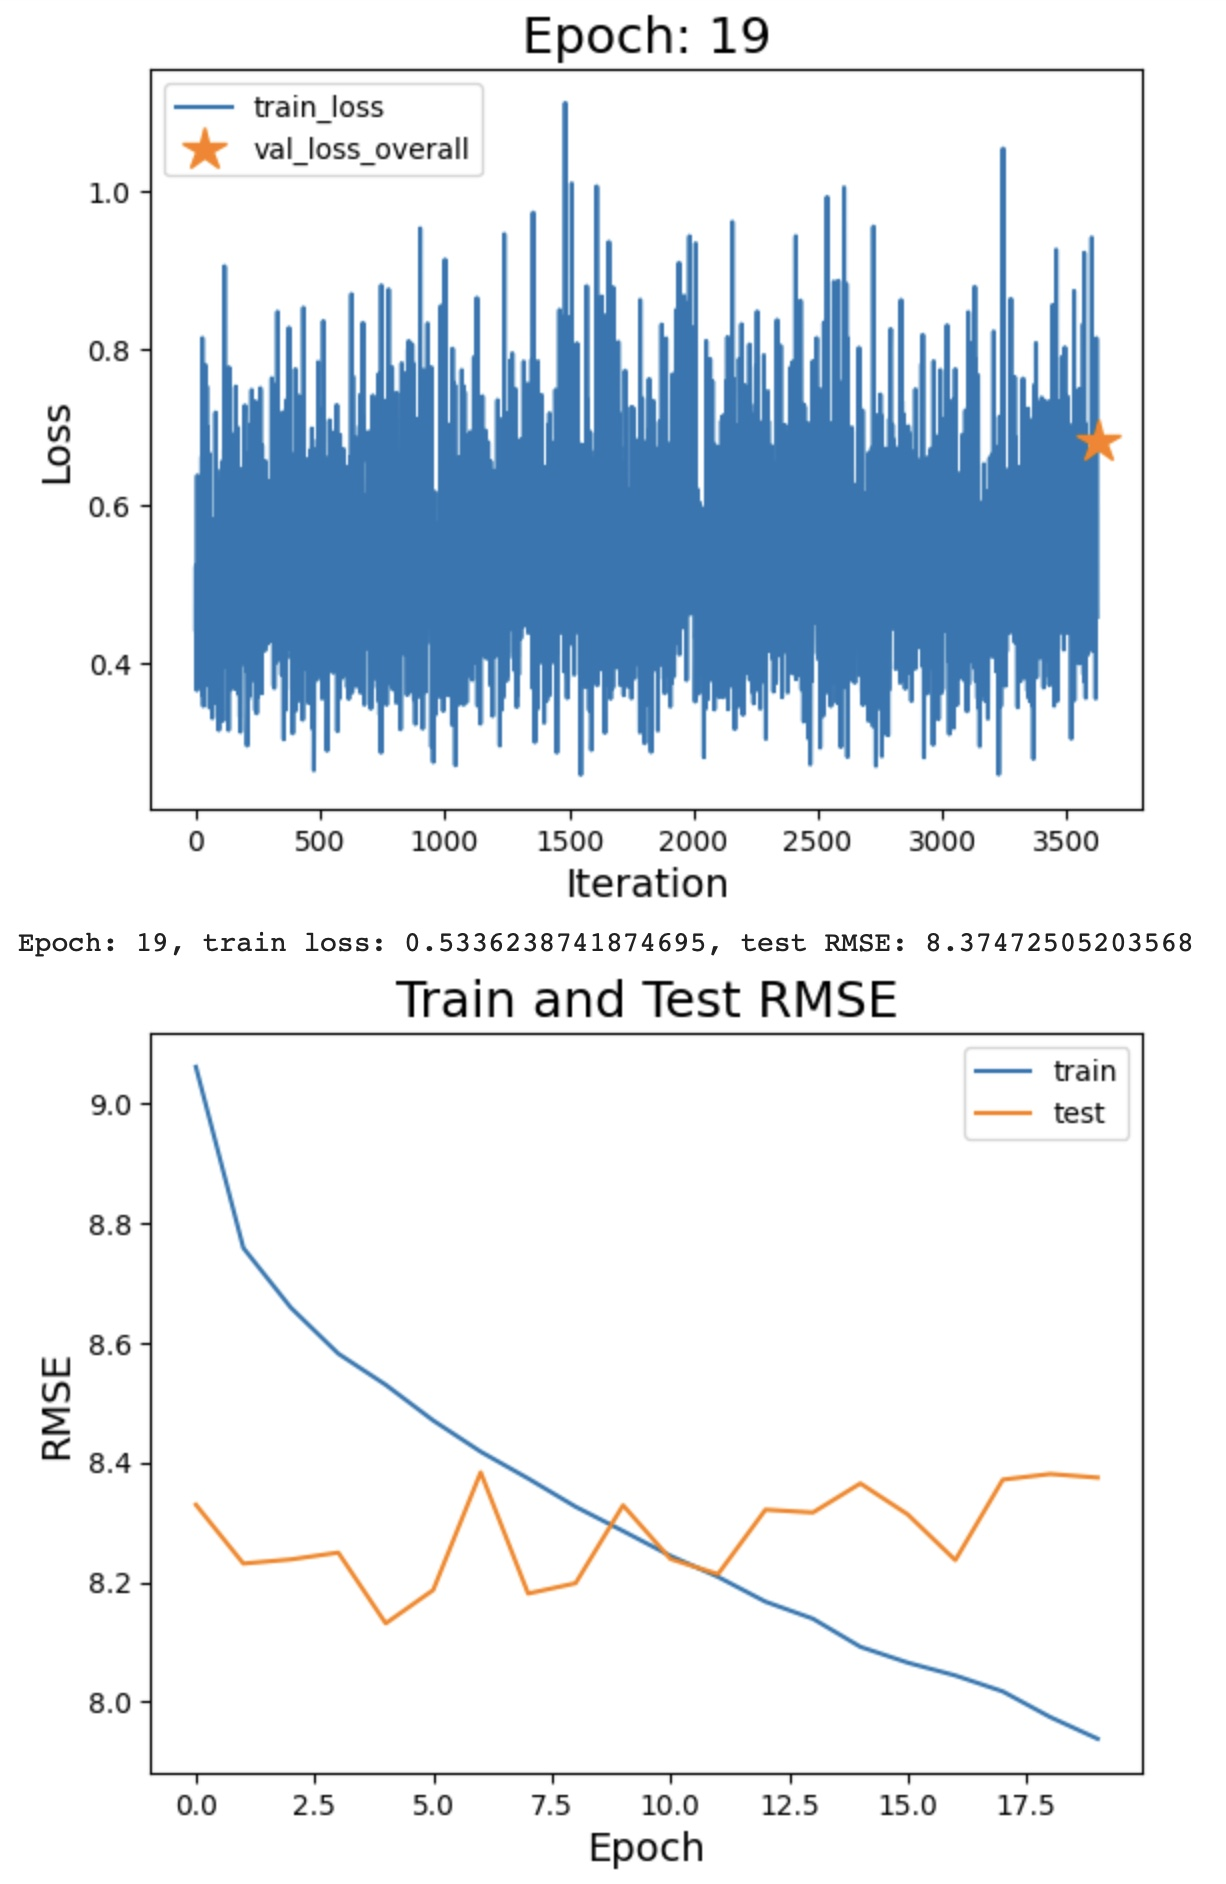

Стало ещё лучше! Теперь test RMSE ни на одной эпохе не превысил 8.75 и после 20-й эпохи стал 8.37. Однако у меня были в запасе ещё идеи того, что можно сделать с моделью.

# Эксперимент 4

Мне просто стало интересно, насколько сильно различаются nn.ReLU и nn.LeakyReLU. Модель почти такая же, как была:

In [ ]:
# batch размером 128
model = nn.Sequential(
    nn.Linear(90, 512), nn.LeakyReLU(), nn.Dropout(0.2),
    nn.Linear(512, 256), nn.LeakyReLU(), nn.Dropout(0.2),
    nn.Linear(256, 128), nn.LeakyReLU(), nn.Dropout(0.2),
    nn.Linear(128, 1)).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
criterion = torch.nn.MSELoss()

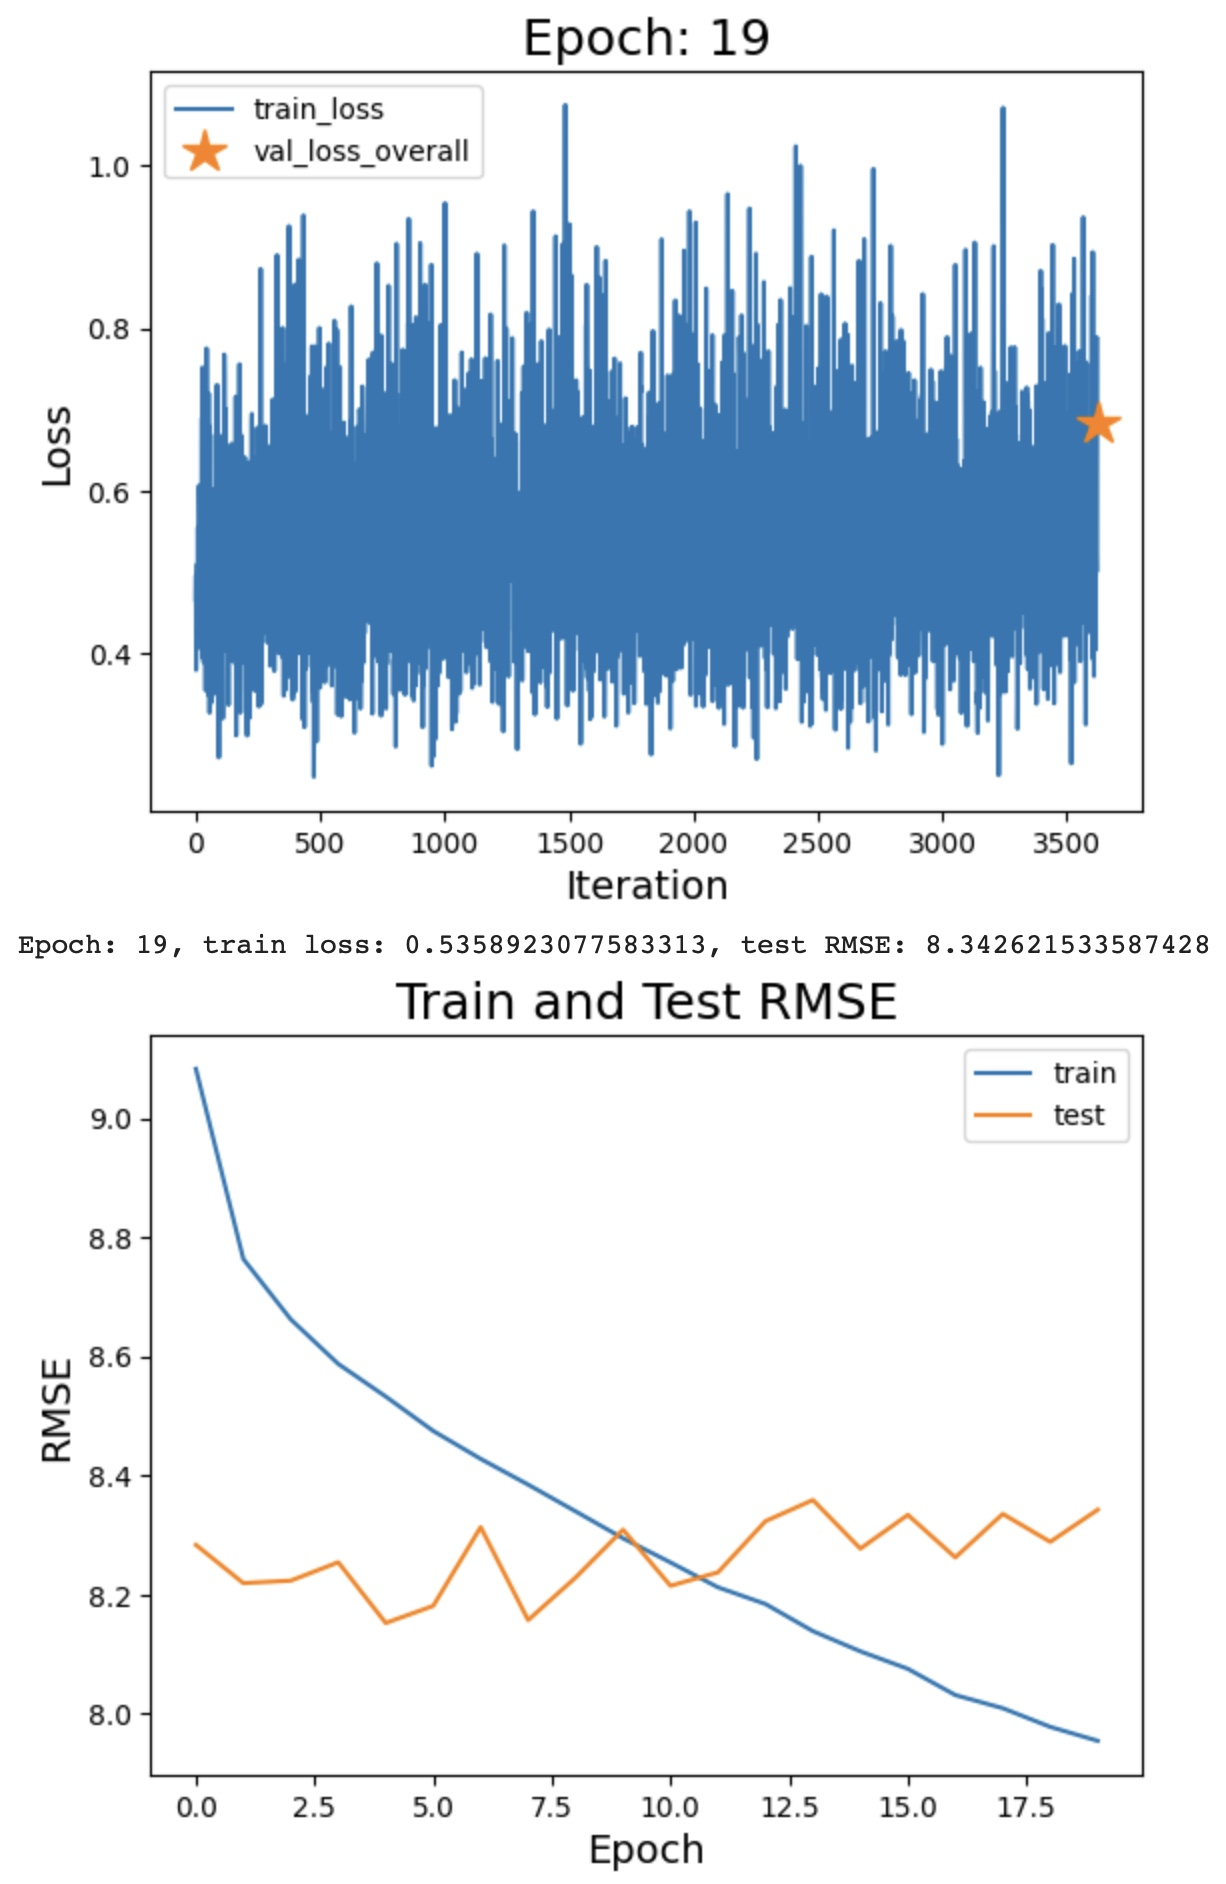

Очень похоже на 3-й эксперимент, но test RMSE к 20-й эпохе стал ещё меньше. В общем, nn.LeakyReLU немного лучше.

# Эксперимент 5

Наконец, я решил заменить SGD на Adam. На лекции нам рассказали про то, какая сложная формула встроена в Adam и насколько популярен этот оптимизатор. Теперь ячейка выглядит так:

In [ ]:
# batch размером 128
model = nn.Sequential(
    nn.Linear(90, 512), nn.LeakyReLU(), nn.Dropout(0.2),
    nn.Linear(512, 256), nn.LeakyReLU(), nn.Dropout(0.2),
    nn.Linear(256, 128), nn.LeakyReLU(), nn.Dropout(0.2),
    nn.Linear(128, 1)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
criterion = torch.nn.MSELoss()

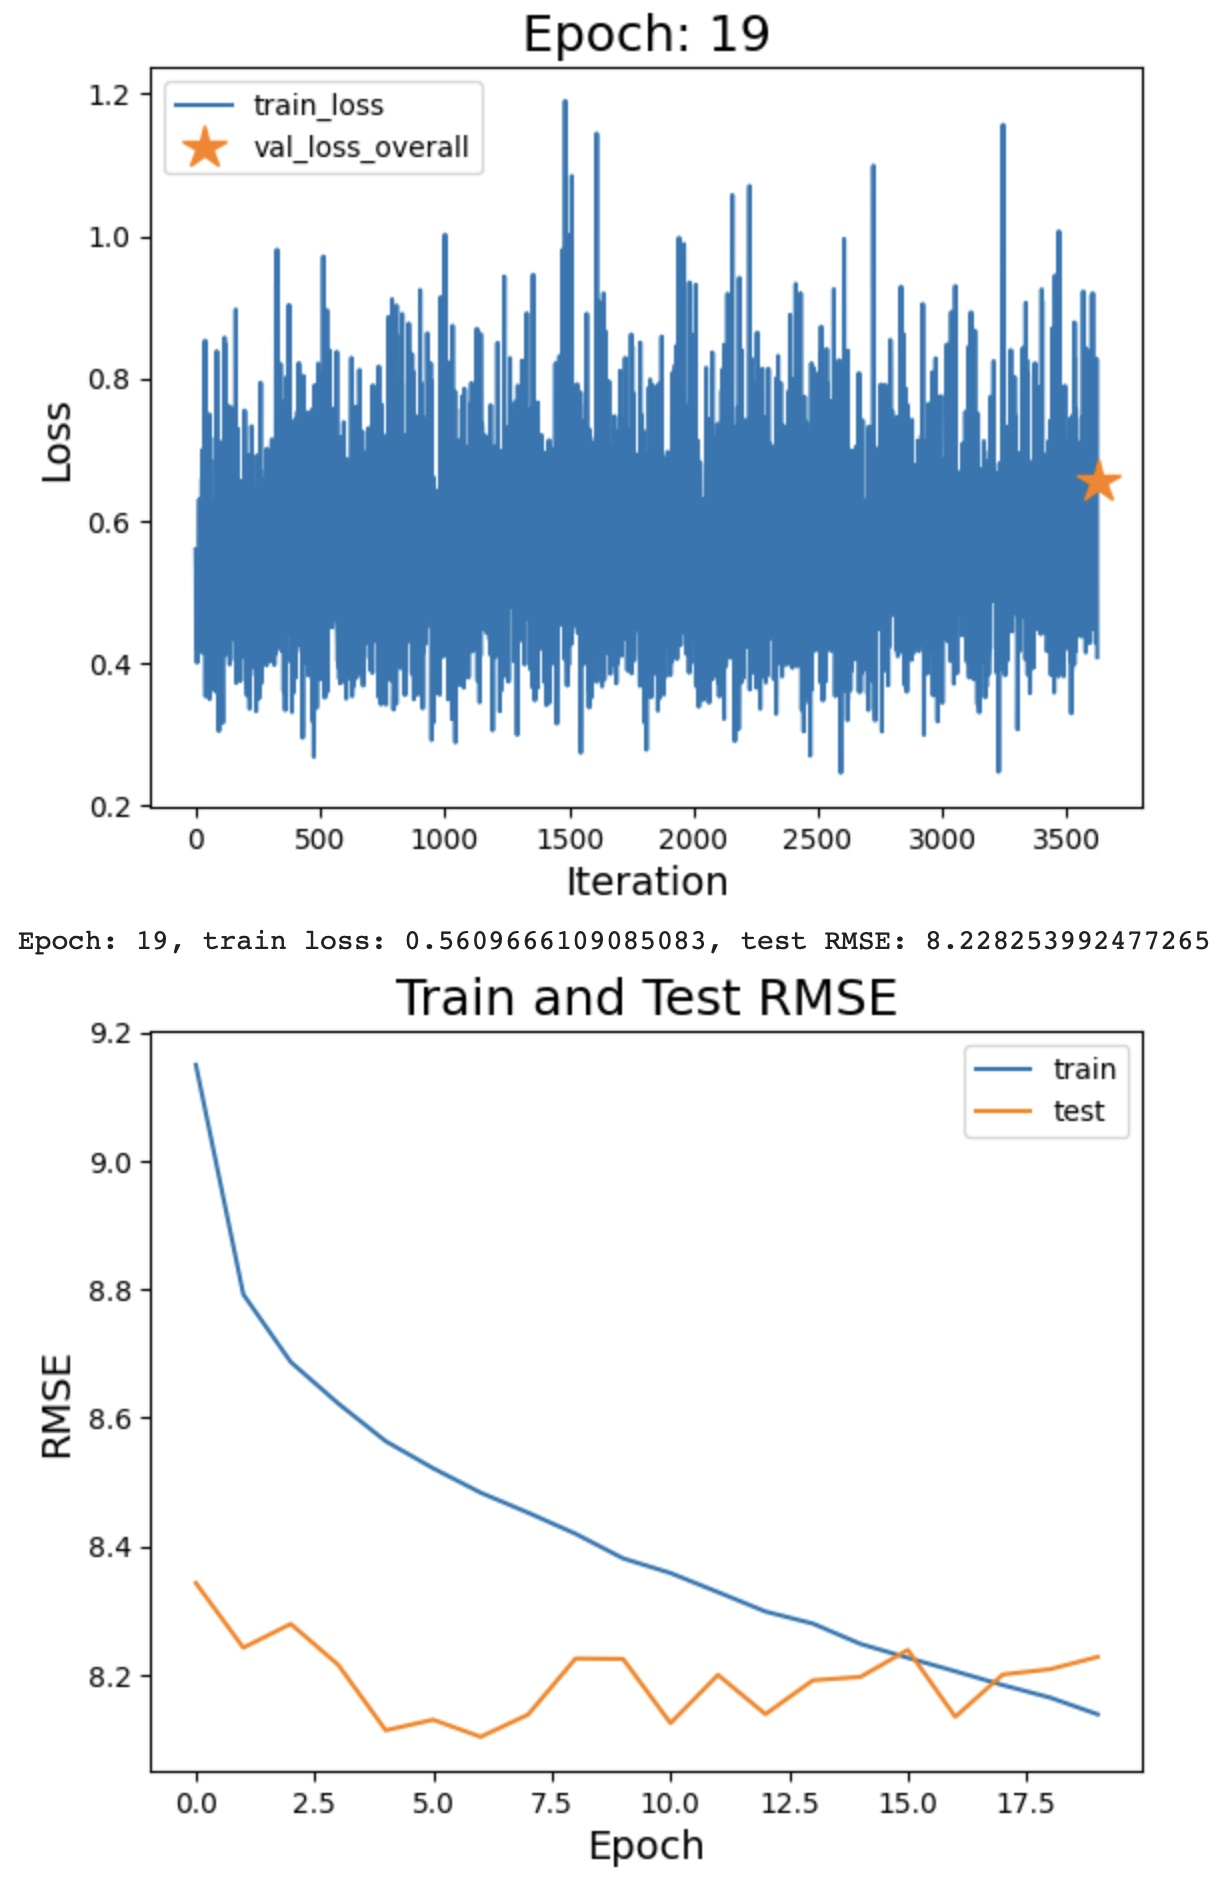

Эта модель лучшая из всех: после 20-й эпохи test RMSE составил 8.23, а на некоторых предыдущих и вовсе был меньше 8.20. Таким образом, для данной задачи Adam оказался эффективнее SGD.

-----
-----